# Autoencoders for humans to animals adaption
# (Using Neural Style Transfer)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image, ImageFile

In [ ]:
BS = 32
NO_OF_SAMPLE = 1
lr = 0.0001
epochs = 3
sz = 64
alpha = 1
beta = 0.5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data = torchvision.datasets.ImageFolder(r'/content/drive/MyDrive/validation',transform = transforms.ToTensor())

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
transform = transforms.Compose([
    transforms.Resize(sz),
    transforms.CenterCrop(sz),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

dataset = torchvision.datasets.ImageFolder(r'/content/drive/MyDrive/CU_dogs',transform = transform)
dataloader = DataLoader(dataset, batch_size=BS,shuffle=True)
humans=torchvision.datasets.ImageFolder(r'/content/drive/MyDrive/humans',transform = transform)
humans_dl = DataLoader(humans, batch_size=BS, shuffle=True)

In [ ]:
x = next(iter(dataloader))
y = next(iter(humans_dl))
print(len(dataset))

8351


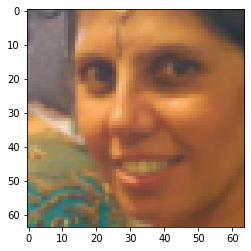

In [ ]:
plt.imshow(inv_normalize(y[0][2]).numpy().transpose(1,2,0))

In [ ]:
content_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
layer_names = ['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
               'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
               'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
               'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
               'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5']

In [ ]:
import torchvision.models as models
class _VGG(nn.Module):
    '''
    Classic pre-trained VGG19 model.
    Its forward call returns a list of the activations from
    the predefined content layers.
    '''

    def __init__(self):
        super(_VGG, self).__init__()
        features = models.vgg19(pretrained=True).features

        self.features = nn.Sequential()
        for i, module in enumerate(features):
            name = layer_names[i]
            self.features.add_module(name, module)

    def forward(self, input):
        batch_size = input.size(0)
        all_outputs = []
        output = input
        for name, module in self.features.named_children():
            output = module(output)
            if name in content_layers:
                all_outputs.append(output.view(BS, -1))
        return all_outputs

In [ ]:
class DfcVae(nn.Module):
    def __init__(self, latent_dim=100, leaky_relu=0.2):
        super().__init__()
        self.leaky_relu = leaky_relu
        self.encoder = self.create_encoder(latent_dim)
        # not sure about this FC part tbh
        self.fc = nn.Sequential(nn.Linear(latent_dim, 4096), nn.ReLU(True))
        self.decoder = self.create_decoder()
    
    def encode(self, x):
        x = self.encoder(x)
        return x[:, :100], x[:, 100:]

    def decode(self, z):
        z = self.decoder(z)
        return z.view(-1, 3*64*64)
    
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
  
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        z = self.fc(z)
        z = z.view(-1, 256, 4, 4)
        x_bar = self.decoder(z)
        return x_bar, mu, logvar
    
    def create_conv_block(self, in_c, out_c, stride=2, kernel=(4,4), padding=1):
        return [
            nn.Conv2d(in_c, out_c, kernel, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(self.leaky_relu, True)
        ]
    
    def create_encoder(self, latent_dim):
        encoder_as_list = self.create_conv_block(3, 32)
        encoder_as_list += self.create_conv_block(32, 64)
        encoder_as_list += self.create_conv_block(64, 128)
        encoder_as_list += self.create_conv_block(128, 256)
        encoder_as_list += [nn.Flatten(), nn.Linear(256*4*4, latent_dim*2)]
        return nn.Sequential(*encoder_as_list)
    
    def create_decode_block(self, in_c, out_c, stride=1, kernel=(3,3), scale=2, final=False):
        block = [
            nn.UpsamplingNearest2d(scale_factor=scale),
            nn.Conv2d(in_c, out_c, kernel, stride=stride, padding_mode='replicate', padding=1)
        ]
        
        if not final:
            block += [
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU()
            ]
        return block
            
    def create_decoder(self):
        decoder_as_list = self.create_decode_block(256, 128)
        decoder_as_list += self.create_decode_block(128, 64)
        decoder_as_list += self.create_decode_block(64, 32)
        decoder_as_list += self.create_decode_block(32, 3, final=True)
        return nn.Sequential(*decoder_as_list)
    
    def predict(self, z):
        z = self.fc(z)
        z = z.view(-1, 256, 4, 4)
        z = self.decoder(z)
        return z

In [ ]:
class KLDLoss(nn.Module):
    def __init__(self, reduction='sum'):
        super(KLDLoss, self).__init__()
        self.reduction = reduction

    def forward(self, mean, logvar):
        # KLD loss
        kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp(), 1)
        # Size average
        if self.reduction == 'mean':
            kld_loss = torch.mean(kld_loss)
        elif self.reduction == 'sum':
            kld_loss = torch.sum(kld_loss)
        return kld_loss

class FLPLoss(nn.Module):
    def __init__(self, device, reduction='sum'):
        super(FLPLoss, self).__init__()
        self.criterion = nn.MSELoss(reduction=reduction)
        self.pretrained = _VGG().to(device)
    
    def forward(self, x, recon_x):
        x_f = self.pretrained(x)
        recon_f = self.pretrained(recon_x)
        return self._fpl(recon_f, x_f)

    def _fpl(self, recon_f, x_f):
        fpl = 0
        for _r, _x in zip(recon_f, x_f):
            fpl += self.criterion(_r, _x)
        return fpl

In [ ]:
def process_image_paths(image_paths):
    test_images = Variable(torch.randn(len(image_paths), 3, sz, sz)).to(device)
    for idx, path in enumerate(image_paths):
        img = Image.open(path).convert('RGB')
        img = transform(img)
        test_images[idx] = img
    return test_images

def test_on_images(model, test_images):
    model.eval()
    recon, _, _ = model(test_images)
    fig = plt.figure(figsize=(5, 5))
    for ii, img in enumerate(recon):
        ax = fig.add_subplot(2, test_images.shape[0], ii + 1, xticks=[], yticks=[])
        plt.imshow(inv_normalize(test_images[ii]).cpu().numpy().transpose(1, 2, 0))
        ax = fig.add_subplot(2, test_images.shape[0], ii + test_images.shape[0] + 1, xticks=[], yticks=[])
        plt.imshow(inv_normalize(recon[ii]).detach().cpu().numpy().transpose(1, 2, 0))

In [ ]:
# Dogs
validation_paths = ["/content/drive/MyDrive/validation/dogs/akita_003.jpg", 
                    "/content/drive/MyDrive/validation/dogs/american_staffordshire_terrier_002.jpg", 
                    "/content/drive/MyDrive/validation/dogs/american_water_spaniel_005.jpg", 
                    "/content/drive/MyDrive/validation/dogs/belgian_tervuren_001.jpg"]
validation_paths_two = ["/content/drive/MyDrive/validation/dogs/greyhound_004.jpg",
                        "/content/drive/MyDrive/validation/dogs/havanese_004.jpg",
                        "/content/drive/MyDrive/validation/dogs/tibetan_mastiff_001.jpg",
                        "/content/drive/MyDrive/validation/dogs/yorkshire_terrier_002.jpg"]

# Faces
validation_paths_three = [
  "/content/drive/MyDrive/validation/humans/1303.jpg",
  "/content/drive/MyDrive/validation/humans/1304.jpg",
  "/content/drive/MyDrive/validation/humans/1305.jpg",
  "/content/drive/MyDrive/validation/humans/1306.jpg"]
validation_paths_four = [
  "/content/drive/MyDrive/validation/humans/1315.jpg",
  "/content/drive/MyDrive/validation/humans/1316.jpg",
  "/content/drive/MyDrive/validation/humans/1317.jpg",
  "/content/drive/MyDrive/validation/humans/1318.jpg"]


to_validate = process_image_paths(validation_paths)
to_validate_two = process_image_paths(validation_paths_two)
to_validate_three = process_image_paths(validation_paths_three)
to_validate_four = process_image_paths(validation_paths_four)

In [ ]:
def load_model(model_construct, path=None):
    model = model_construct()
    if path is not None:
        model.load_state_dict(torch.load(path))
    return model

model = load_model(DfcVae, '/content/drive/MyDrive/autoencode-trained')
model.to(device)

DfcVae(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=20

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 0 [0/9 (0%)]	Loss: 10239509.000000	VGG: 10231918.000000	KLD: 15181.619141
Epoch: 0 has running loss 1137723.250000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 1 [0/9 (0%)]	Loss: 9587232.000000	VGG: 9579633.000000	KLD: 15198.728516
Epoch: 1 has running loss 1065248.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 2 [0/9 (0%)]	Loss: 9099064.000000	VGG: 9091459.000000	KLD: 15210.864258
Epoch: 2 has running loss 1011007.125000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 3 [0/9 (0%)]	Loss: 8715061.000000	VGG: 8707443.000000	KLD: 15235.799805
Epoch: 3 has running loss 968340.125000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 4 [0/9 (0%)]	Loss: 8402067.000000	VGG: 8394430.000000	KLD: 15273.976562
Epoch: 4 has running loss 933563.000000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 5 [0/9 (0%)]	Loss: 8136832.500000	VGG: 8129172.000000	KLD: 15321.085938
Epoch: 5 has running loss 904092.500000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 6 [0/9 (0%)]	Loss: 7904748.000000	VGG: 7897063.000000	KLD: 15370.340820
Epoch: 6 has running loss 878305.312500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Train Epoch: 7 [0/9 (0%)]	Loss: 7700101.500000	VGG: 7692392.000000	KLD: 15419.008789
Epoch: 7 has running loss 855566.812500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

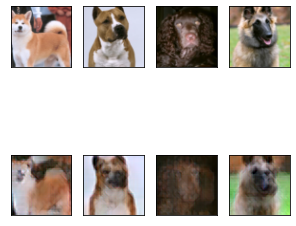

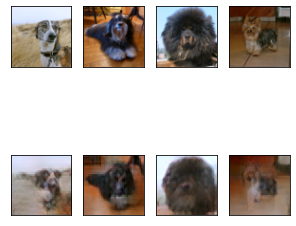

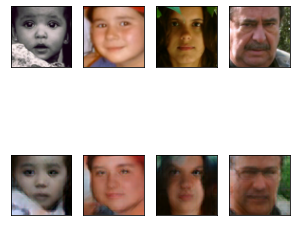

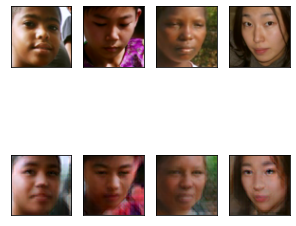

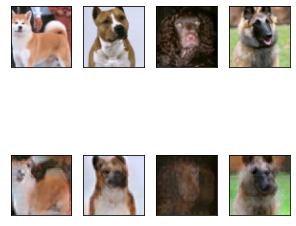

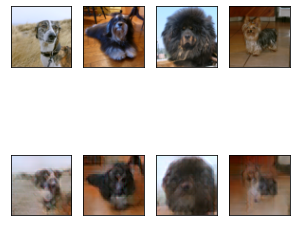

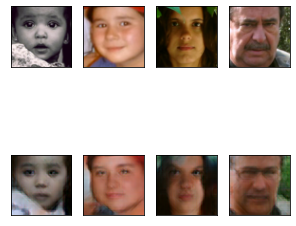

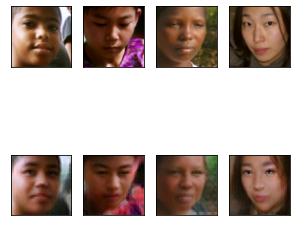

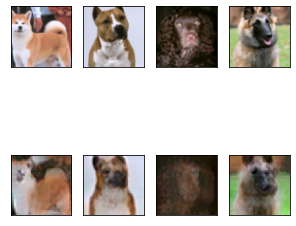

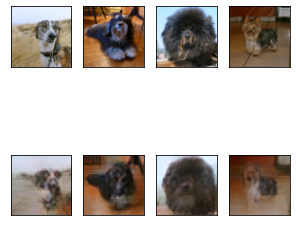

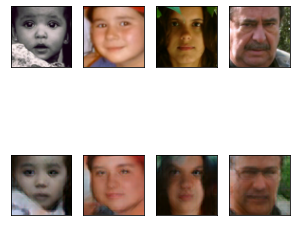

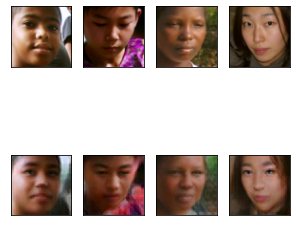

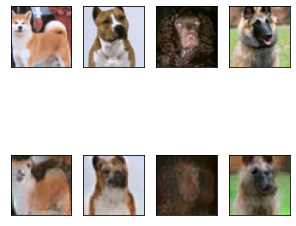

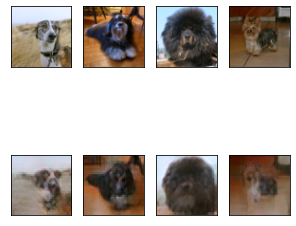

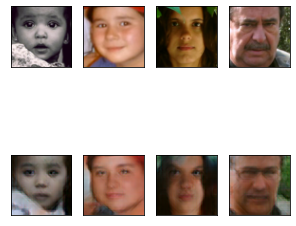

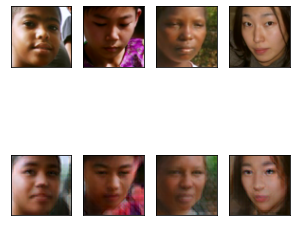

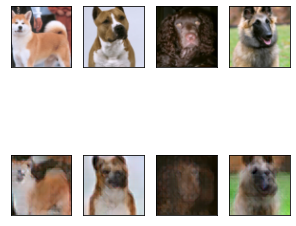

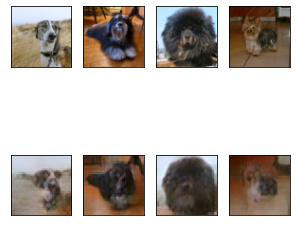

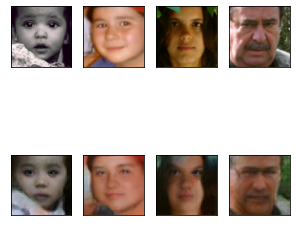

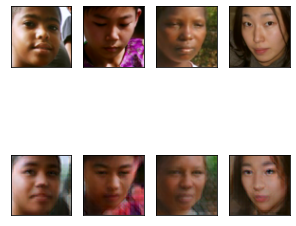

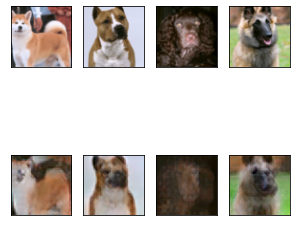

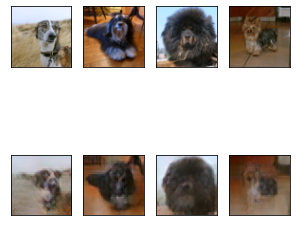

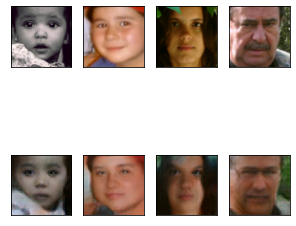

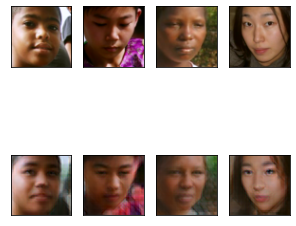

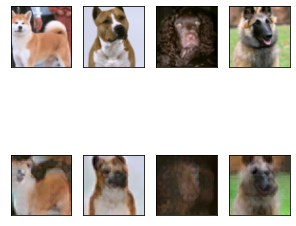

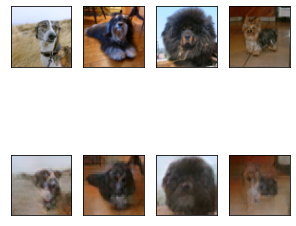

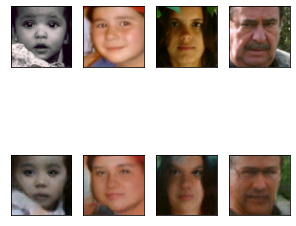

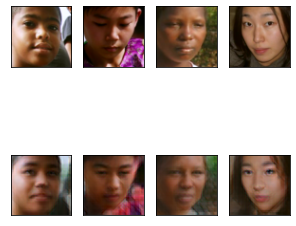

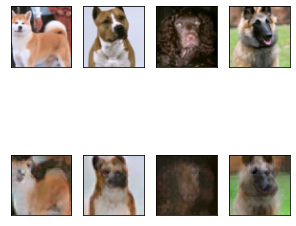

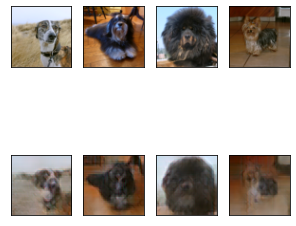

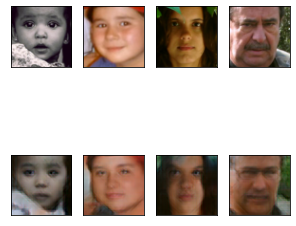

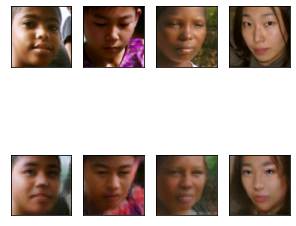

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
calc_kld = KLDLoss()
calc_flp = FLPLoss(device)
def train(model, name, dataloader):
    for epoch in range(8):
        model.train()
        running_loss = 0.0
        data_num = 0
        for batch_idx, data in enumerate(dataloader):
            data = data[0].to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(data)
            
            # Loss
            kld_loss = calc_kld(mu, logvar)
            flp_loss = calc_flp(data, recon_x)
            total_loss = alpha*flp_loss + beta*kld_loss
            
            # Train
            total_loss.backward()
            optimizer.step()
            
            # Metrics
            running_loss += total_loss
            data_num += data.size(0)
            if batch_idx % 25 == 0:
                loss_data = total_loss.data
                print(
                      'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tVGG: {:.6f}\tKLD: {:.6f}'.
                      format(epoch, batch_idx * len(data), len(dataloader.dataset),
                        100. * batch_idx / len(dataloader), loss_data, flp_loss, kld_loss))
                
        epoch_loss = running_loss / data_num
        print("Epoch: {} has running loss {:.6f}".format(epoch, epoch_loss))
        
        for validation in [to_validate, to_validate_two, to_validate_three, to_validate_four]:
            test_on_images(model, validation)
            
train(model, "vgg", humans_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


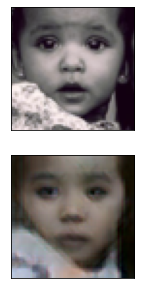

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


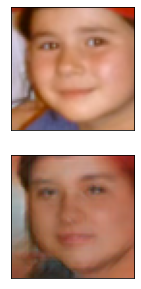

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


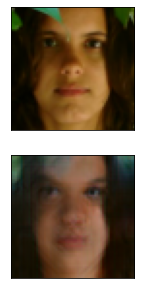

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


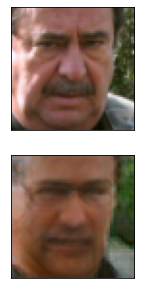

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


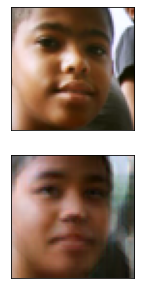

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


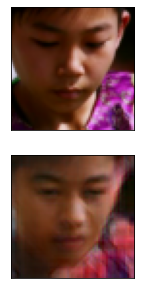

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


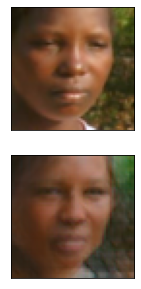

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


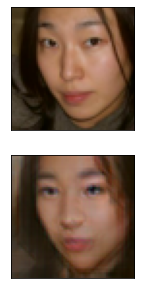

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1303.jpg


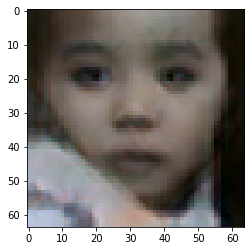

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1304.jpg


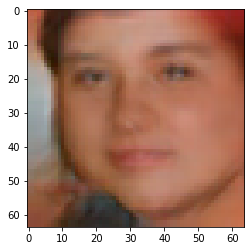

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1305.jpg


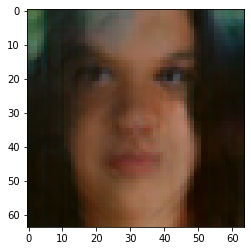

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1306.jpg


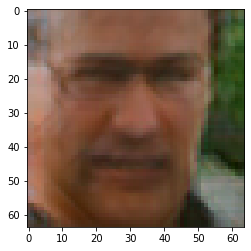

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1315.jpg


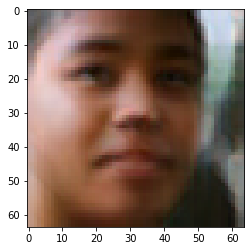

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1316.jpg


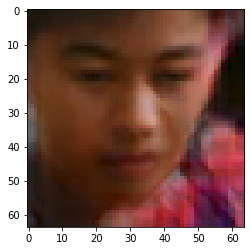

1317.jpg


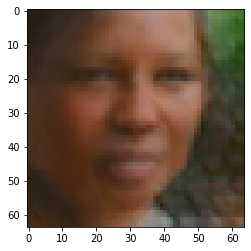

1318.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


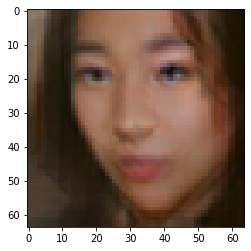

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/autoencode-trained")
def print_in_threes(images, model):
    ind = 0
    while ind < len(images):
        test_on_images(model, images[ind:ind+3])
        plt.show()
        ind+=3        

def apply_fn_to_humans_dir(fn, base_dir):   
    peoples = os.listdir(base_dir)
    for people in peoples:
        cwd = base_dir +'/'+ people
        validate_me = [cwd]
        images = process_image_paths(validate_me)
        fn(images, people)

apply_fn_to_humans_dir(lambda x, y: print_in_threes(x, model), "/content/drive/MyDrive/validation/humans")
def get_average(model, imgs):
    model.eval()
    _, mu, _ = model(imgs)
    mu_avg = torch.mean(mu, 0)
    std_avg = torch.std(mu, 0)
    return mu_avg, std_avg/1.5


def add_average_to_dict(images, name, model):
    mu, std = get_average(model, images)
    average_dict[name] = (mu, std)
average_dict = {}
apply_fn_to_humans_dir(lambda x, y: add_average_to_dict(x, y, model), "/content/drive/MyDrive/validation/humans")
for k, v in average_dict.items():
    print(k)
    mu = v[0].unsqueeze(0)
    recon = model.predict(mu)
    plt.imshow((inv_normalize(recon[0]).detach().cpu().numpy().transpose(1,2,0)))
    plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


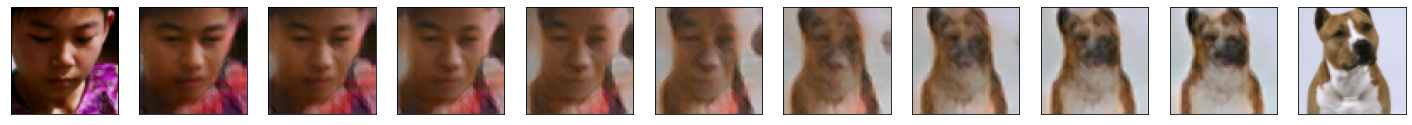

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


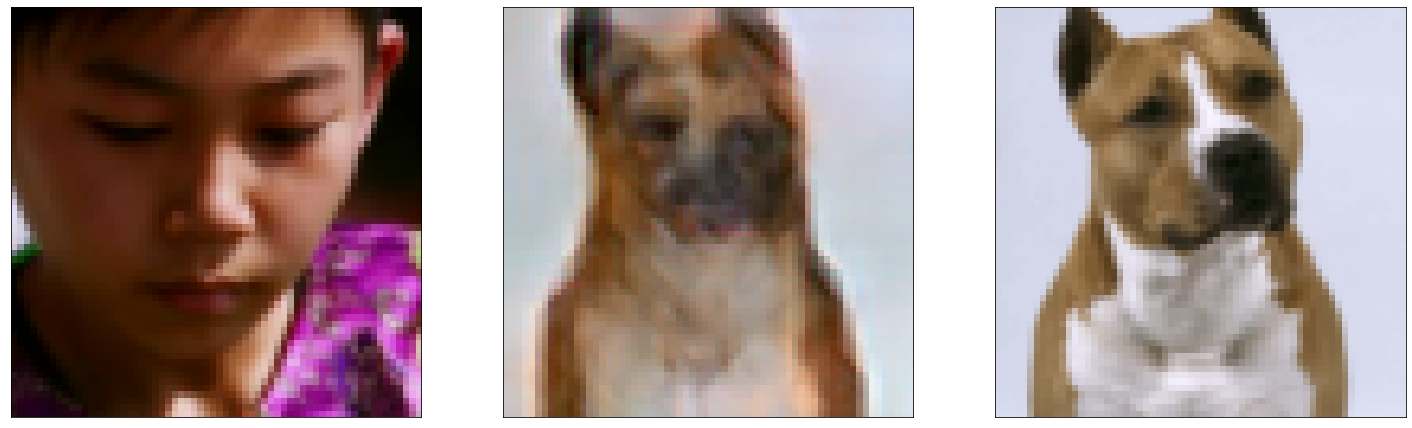

In [ ]:
images = next(iter(dataloader))
def get_mus_and_logvar(model, data):
    model.eval()
    recon, mu, logvar = model(data)
    return mu, logvar

def latent_walk(imgs, model, latent_dim=100, steps=10):
    orig_transformed = imgs[0]
    final_transformed = imgs[1]
    mu, _ = get_mus_and_logvar(model, imgs)
    
    path = Variable(torch.randn(steps+1, latent_dim)).to(device)
    delta = 1.0/steps
    for i in range(steps + 1):
        alpha = i*delta
        path[i] = (1.0 - alpha)*mu[0] + alpha*mu[1]
  
    path  = model.predict(path)

    fig = plt.figure(figsize=(25, 16))
    ax = fig.add_subplot(1, steps+3, 1, xticks=[], yticks=[])
    
    plt.imshow((inv_normalize(orig_transformed).cpu().numpy().transpose(1,2,0)))
    for ii, img in enumerate(path):
        ax = fig.add_subplot(1, steps+3, ii + 2, xticks=[], yticks=[])
        plt.imshow(inv_normalize(img).detach().cpu().numpy().transpose(1,2,0))

    ax = fig.add_subplot(1, steps+3, steps+3, xticks=[], yticks=[])
    plt.imshow((inv_normalize(final_transformed).cpu().numpy().transpose(1,2,0)))
    plt.show()

def add_images(imgs, model, latent_dim=100, alpha=1.0, beta=1.0, div=False):
    orig_transformed = imgs[0]
    final_transformed = imgs[1]
    mu, _ = get_mus_and_logvar(model, imgs)
    summed_mu = alpha*mu[0] + beta*mu[1]
    if div:
        summed_mu/=2.0
  
    added  = model.predict(summed_mu)
    fig = plt.figure(figsize=(25, 16))
    
    ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
    plt.imshow((inv_normalize(orig_transformed).cpu().numpy().transpose(1,2,0)))
    
    ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
    plt.imshow(inv_normalize(added[0]).detach().cpu().numpy().transpose(1,2,0))
    
    ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
    plt.imshow((inv_normalize(final_transformed).cpu().numpy().transpose(1,2,0)))
    
    plt.show()
images = process_image_paths([
    "/content/drive/MyDrive/validation/humans/1316.jpg",
    "/content/drive/MyDrive/validation/dogs/american_staffordshire_terrier_002.jpg"
])

latent_walk(images, model, steps=8)
add_images(images, model, alpha=0.2, beta=1.0)